# Spam Classification

In this project we are going to explore Ham and Spam emails provided at https://www.kaggle.com/veleon/ham-and-spam-dataset and test the performance of Random Forest and Gradient Boosting algorithms in predicting the Spam emails.
The database contains email files. In this project I'll import them, explore them, create features and train some models based on the data to classify Spams.

## Summary

### 1 - Reading, Analyzing and Cleaning Text
### 2 - Feature Engineering
### 3 - Building Machine Learning Classifiers: Model selection using grid search and 5-fold cross-validation
### 4 - Building Machine Learning Classifiers: Final evaluation of the best model

Loading packages

In [1]:
import time
import os
import re
import pandas as pd
import numpy as np
import email
import email.policy
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## 1 - Reading, Analyzing and Cleaning Text

Counting the number of Ham and Spam files

In [2]:
email_path = 'input/hamnspam/'
ham_path = email_path+ 'ham/'
spam_path = email_path+ 'spam/'
ham_filenames = os.listdir(ham_path)
spam_filenames = os.listdir(spam_path)
print('Number of Spam emails:', len(spam_filenames))
print('Number of Ham emails:', len(ham_filenames))
print('Spam percentage: ',round(100*(len(spam_filenames)/(len(ham_filenames)+len(spam_filenames))),2),"%")

Number of Spam emails: 501
Number of Ham emails: 2551
Spam percentage:  16.42 %


Opening Emails

In [3]:
def load_email(path, filename):
    with open(os.path.join(path, filename), 'rb') as file:
          email_file = email.parser.BytesParser(policy=email.policy.default).parse(file)
    return email_file
ham_emails = [load_email(ham_path, filename) for filename in ham_filenames]
spam_emails = [load_email(spam_path, filename) for filename in spam_filenames]

Checking the email data

In [4]:
print(ham_emails[2].get_content())

Man Threatens Explosion In Moscow 

Thursday August 22, 2002 1:40 PM
MOSCOW (AP) - Security officers on Thursday seized an unidentified man who
said he was armed with explosives and threatened to blow up his truck in
front of Russia's Federal Security Services headquarters in Moscow, NTV
television reported.
The officers seized an automatic rifle the man was carrying, then the man
got out of the truck and was taken into custody, NTV said. No other details
were immediately available.
The man had demanded talks with high government officials, the Interfax and
ITAR-Tass news agencies said. Ekho Moskvy radio reported that he wanted to
talk with Russian President Vladimir Putin.
Police and security forces rushed to the Security Service building, within
blocks of the Kremlin, Red Square and the Bolshoi Ballet, and surrounded the
man, who claimed to have one and a half tons of explosives, the news
agencies said. Negotiations continued for about one and a half hours outside
the building, ITAR-

In [5]:
email_subject = ham_emails[2].get_all('Subject')
email_from = ham_emails[2].get_all('From')
email_to = ham_emails[2].get_all('To')

print('Email from: ',email_from)
print('Email to: ',email_to)
print('Email subject: ',email_subject)

Email from:  ['Tim Chapman <timc@2ubh.com>']
Email to:  ['zzzzteana <zzzzteana@yahoogroups.com>']
Email subject:  ['[zzzzteana] Moscow bomber']


Transforming Emails into plaintext

In [6]:
from collections import Counter

def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

ham_structure = structures_counter(ham_emails)
spam_structure = structures_counter(spam_emails)
print('Ham most common content types and frequencies:',ham_structure.most_common())
print('Spam most common content types and frequencies:',spam_structure.most_common())

Ham most common content types and frequencies: [('text/plain', 2453), ('multipart(text/plain, application/pgp-signature)', 72), ('multipart(text/plain, text/html)', 8), ('multipart(text/plain, text/plain)', 4), ('multipart(text/plain)', 3), ('multipart(text/plain, application/octet-stream)', 2), ('multipart(text/plain, text/enriched)', 1), ('multipart(text/plain, application/ms-tnef, text/plain)', 1), ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)', 1), ('multipart(text/plain, video/mng)', 1), ('multipart(text/plain, multipart(text/plain))', 1), ('multipart(text/plain, application/x-pkcs7-signature)', 1), ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)', 1), ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))', 1), ('multipart(text/plain, application/x-java-applet)', 1)]
Spam most common content types and frequencies: [('text/plain', 222), ('tex

In [7]:
for email in spam_emails:
    if get_email_structure(email) == 'text/html':
        testEmail = email
        break

print(testEmail.get_content())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<HTML><HEAD>
<META content="text/html; charset=windows-1252" http-equiv=Content-Type>
<META content="MSHTML 5.00.2314.1000" name=GENERATOR></HEAD>
<BODY><!-- Inserted by Calypso -->
<TABLE border=0 cellPadding=0 cellSpacing=2 id=_CalyPrintHeader_ rules=none 
style="COLOR: black; DISPLAY: none" width="100%">
  <TBODY>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TD></TR>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso --><FONT 
color=#000000 face=VERDANA,ARIAL,HELVETICA size=-2><BR></FONT></TD></TR></TABLE><!-- End Calypso --><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Why Spend More Than You Have To?
<CENTER><FONT color=#ff0000 face="Copp

## 2 - Feature Engineering

In [8]:
import nltk
wn = nltk.WordNetLemmatizer()

emails = ham_emails + spam_emails
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

df = pd.DataFrame(columns=['body_text','body_lenght','label'])
for email in emails:
    if email in ham_emails:
        label = 'ham'
    else:
        label = 'spam'
    try:
        if email.get_content_type() == 'text/plain' or email.get_content_type() == 'text/html' :
            l = email.get_content()
            l = cleanhtml(l)
            l = l.replace('\n',' ')
            s = re.sub(r"[^a-zA-Z0-9]+", ' ', l)
            s= s.lower()
            tokens = re.split('\s+', s)
            text = [wn.lemmatize(word) for word in tokens]
            df = df.append({
                 "body_text": s,
                 "body_lenght":  len(email.get_content()),
                 "body_text_lemmatized": text,
                 "label":  label                
                  }, ignore_index=True)
    except LookupError: pass
df.head()

,body_text,body_lenght,label,body_text_lemmatized
0,date wed 21 aug 2002 10 54 46 0500 from chris...,1604,ham,"[, date, wed, 21, aug, 2002, 10, 54, 46, 0500,..."
1,martin a posted tassos papadopoulos the greek ...,899,ham,"[martin, a, posted, tasso, papadopoulos, the, ..."
2,man threatens explosion in moscow thursday aug...,1751,ham,"[man, threatens, explosion, in, moscow, thursd..."
3,klez the virus that won t die already the most...,1127,ham,"[klez, the, virus, that, won, t, die, already,..."
4,on wed aug 21 2002 at 15 46 ulises ponce wrote...,1297,ham,"[on, wed, aug, 21, 2002, at, 15, 46, ulises, p..."


### Histograms of Emails Body Lenght

C:\ProgramData\Anaconda3\envs\py377\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


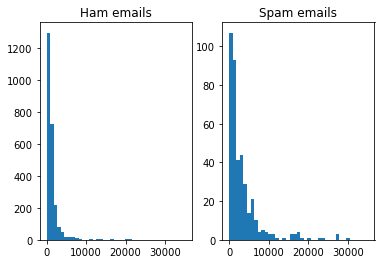

In [9]:
bins = np.linspace(0, 35000, 40)

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(df['body_lenght'][df['label']=='ham'], bins)
ax1.set_title('Ham emails')
ax2.hist(df['body_lenght'][df['label']=='spam'], bins)
ax2.set_title('Spam emails')
f.show()

## 3 - Building Machine Learning Classifiers: Model selection using grid search and 5-fold cross-validation


### Comparison between Random Forest and Gradient Boosting using 5-fold cross validation

In [10]:
tfidf_vect = TfidfVectorizer()
tfidf_vect_fit = tfidf_vect.fit(df['body_text'])

tfidf_df = tfidf_vect_fit.transform(df['body_text'])
tfidf_df_feat = pd.concat([df[['body_lenght']].reset_index(drop=True), 
           pd.DataFrame(tfidf_df.toarray())], axis=1)

In [11]:
count_vect = CountVectorizer()
count_vect_fit = tfidf_vect.fit(df['body_text'])

count_df = tfidf_vect_fit.transform(df['body_text'])
count_df_feat = pd.concat([df[['body_lenght']].reset_index(drop=True), 
           pd.DataFrame(count_df.toarray())], axis=1)

Random Forest for TF-IDF

In [13]:
rf = RandomForestClassifier()
param = {'n_estimators': [10, 150, 300],
        'max_depth': [30, 60, 90, None]}

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)
gs_fit = gs.fit(tfidf_df_feat, df['label'])
rf_tf_idf = pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)

Random Forest for CountVectorize

In [14]:
rf = RandomForestClassifier()
param = {'n_estimators': [10, 150, 300],
        'max_depth': [30, 60, 90, None]}

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)
gs_fit = gs.fit(count_df_feat, df['label'])
rf_count = pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)

Gradient Boosting for TF-IDF

In [15]:
gb = GradientBoostingClassifier()
param = {
    'n_estimators': [50,100, 150], 
    'max_depth': [3, 7, 11, 15],
    'learning_rate': [0.01,0.1,1]
}

clf = GridSearchCV(gb, param, cv=5, n_jobs=-1)
cv_fit = clf.fit(tfidf_df_feat, df['label'])
gb_tf_idf = pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_score', ascending=False)

Gradient Boosting for CountVectorize

In [16]:
gb = GradientBoostingClassifier()
param = {
    'n_estimators': [50,100, 150], 
    'max_depth': [3, 7, 11, 15],
    'learning_rate': [0.01,0.1,1]
}

clf = GridSearchCV(gb, param, cv=5, n_jobs=-1)
cv_fit = clf.fit(count_df_feat, df['label'])
gb_count = pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_score', ascending=False)

Choosing the best model based on mean_test_score

In [26]:
modelresults = pd.concat([rf_tf_idf,rf_count,gb_tf_idf,gb_count], keys=['rf_tf_idf', 'rf_count', 'gb_tf_idf', 'gb_count']).reset_index(
    level=[0]).sort_values('mean_test_score', ascending=False)
modelresults.head()

,level_0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,param_learning_rate
14,gb_count,213.821889,4.679108,2.745308,0.234809,3,150,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.945709,0.982487,0.968476,0.950877,0.987719,0.967054,0.016641,1,0.1
14,gb_tf_idf,235.344708,17.611809,2.858265,0.264643,3,150,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.942207,0.980736,0.968476,0.950877,0.987719,0.966003,0.017262,1,0.1
17,gb_tf_idf,423.021216,14.018385,2.676150,0.062050,7,150,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.945709,0.978984,0.961471,0.947368,0.987719,0.964250,0.016759,2,0.1
13,gb_count,146.190087,5.242759,3.458575,1.671116,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.940455,0.980736,0.966725,0.943860,0.985965,0.963548,0.018595,2,0.1
13,gb_tf_idf,145.414365,5.312552,2.622983,0.049323,3,100,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.938704,0.980736,0.966725,0.943860,0.985965,0.963198,0.019038,3,0.1


Gradient Boosting  with CountVectorizer showed the best results. 

## Final evaluation of the best model

### Split into train/test

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df[['body_text', 'body_lenght','label']], df['label'], test_size=0.2)

### Vectorize test

We are going to use CountVectorize only due to the results in the previous section

In [29]:
count_vect = CountVectorizer()
count_vect_fit = count_vect.fit(X_train['body_text'])

count_train = count_vect_fit.transform(X_train['body_text'])
count_test = count_vect_fit.transform(X_test['body_text'])

X_count_train_vect = pd.concat([X_train[['body_lenght']].reset_index(drop=True), 
           pd.DataFrame(count_train.toarray())], axis=1)
X_count_test_vect = pd.concat([X_test[['body_lenght']].reset_index(drop=True), 
           pd.DataFrame(count_test.toarray())], axis=1)

X_count_train_vect.head()

,body_lenght,0,1,2,3,4,5,6,7,8,...,34339,34340,34341,34342,34343,34344,34345,34346,34347,34348
0,1373,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,352,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1384,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4224,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,174,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
gb = GradientBoostingClassifier(n_estimators=150, max_depth=3, learning_rate=0.1)

start = time.time()
gb_model = gb.fit(X_count_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(X_count_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 212.502 / Predict time: 1.475 ---- Precision: 0.975 / Recall: 0.898 / Accuracy: 0.981
